In [10]:
# Jupyter cell 0
%pip -q install pandas numpy scikit-learn pyarrow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Jupyter cell 1
import pandas as pd
import numpy as np
from pathlib import Path

CSV_PATH = Path(r"C:\Users\matth\Downloads\OneDrive_1_10-25-2025\statcast_pitch_swing_data_20240402_20241030_with_arm_angle1.csv", engine="openpyxl")

# Read with date parsing and low_memory off to prevent mixed dtypes
df = pd.read_csv(
    CSV_PATH,
    parse_dates=["game_date"],          # add other date cols if present
    low_memory=False
)

# Optional: enforce expected dtypes (adjust if your columns differ)
num_cols_expect = [
    "bat_speed","swing_length","arm_angle","release_speed","effective_speed",
    "plate_x","plate_z","launch_speed","launch_angle","balls","strikes",
    "outs_when_up"
]
for c in num_cols_expect:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

cat_cols_expect = ["description","pitch_type","zone","stand","p_throws","inning_topbot"]
for c in cat_cols_expect:
    if c in df.columns:
        df[c] = df[c].astype("category")

df.head(3)


C:\Users\matth\AppData\Local\Temp\ipykernel_8652\2086475444.py:6: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  CSV_PATH = Path(r"C:\Users\matth\Downloads\OneDrive_1_10-25-2025\statcast_pitch_swing_data_20240402_20241030_with_arm_angle1.csv", engine="openpyxl")


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,1.32,0.85,-0.85,19.4
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,3,2,5.0,1.0,6.0,1.0,2.82,1.40,-1.40,14.4
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,3,2,5.0,1.0,6.0,1.0,2.37,1.48,-1.48,21.9


In [12]:
# Jupyter cell 2
SWING_EVENTS = {"foul","foul_tip","hit_into_play","swinging_strike","swinging_strike_blocked"}

# Swings subset
sw = df[df["description"].isin(SWING_EVENTS)].copy()
sw["y_whiff"] = sw["description"].isin({"swinging_strike","swinging_strike_blocked"}).astype(int)

# Contacts subset for hard-hit
ct = df[df["description"].isin({"foul","foul_tip","hit_into_play"}) & df["launch_speed"].notna()].copy()
ct["y_hardhit"] = (ct["launch_speed"] >= 95).astype(int)

sw[["description","y_whiff"]].head(3), ct[["description","launch_speed","y_hardhit"]].head(3)




(     description  y_whiff
 0  hit_into_play        0
 1           foul        0
 3  hit_into_play        0,
      description  launch_speed  y_hardhit
 0  hit_into_play          61.9          0
 1           foul          69.0          0
 3  hit_into_play          31.7          0)

In [13]:
# Jupyter cell 3
feat_num = [c for c in [
    "bat_speed","swing_length","arm_angle","release_speed","effective_speed",
    "plate_x","plate_z","balls","strikes","outs_when_up"
] if c in df.columns]

feat_cat = [c for c in [
    "pitch_type","zone","stand","p_throws","inning_topbot"
] if c in df.columns]

# Optional simple interactions
def add_interactions(frame: pd.DataFrame) -> pd.DataFrame:
    if set(["bat_speed","swing_length"]).issubset(frame.columns):
        frame = frame.assign(
            bs_div_sl = frame["bat_speed"] / frame["swing_length"],
            bs_mul_sl = frame["bat_speed"] * frame["swing_length"]
        )
    return frame

sw = add_interactions(sw)
ct = add_interactions(ct)
feat_num += [c for c in ["bs_div_sl","bs_mul_sl"] if c in sw.columns]


In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# Swings split
sw_tr_idx, sw_te_idx = train_test_split(
    sw.index, test_size=0.2, random_state=42, shuffle=True
)
sw_tr = sw.index.isin(sw_tr_idx)
sw_te = sw.index.isin(sw_te_idx)

# Contacts split
ct_tr_idx, ct_te_idx = train_test_split(
    ct.index, test_size=0.2, random_state=42, shuffle=True
)
ct_tr = ct.index.isin(ct_tr_idx)
ct_te = ct.index.isin(ct_te_idx)

# Checks
assert sw_tr.dtype == bool and sw_te.dtype == bool
assert ct_tr.dtype == bool and ct_te.dtype == bool
print("sw train/test:", sw_tr.sum(), sw_te.sum())
print("ct train/test:", ct_tr.sum(), ct_te.sum())


sw train/test: 268163 67041
ct train/test: 188024 47006


In [15]:
# Jupyter cell 5
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_features   = [c for c in feat_num if c in sw.columns]
categorical_feats  = [c for c in feat_cat if c in sw.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
        ]), categorical_feats),
    ],
    remainder="drop"
)

# Build X,y for both tasks
# After defining numeric_features and categorical_feats
X_sw_tr = sw.loc[sw_tr, numeric_features + categorical_feats]
X_sw_te = sw.loc[sw_te, numeric_features + categorical_feats]
y_sw_tr = sw.loc[sw_tr, "y_whiff"].to_numpy()
y_sw_te = sw.loc[sw_te, "y_whiff"].to_numpy()

X_ct_tr = ct.loc[ct_tr, numeric_features + categorical_feats]
X_ct_te = ct.loc[ct_te, numeric_features + categorical_feats]
y_ct_tr = ct.loc[ct_tr, "y_hardhit"].to_numpy()
y_ct_te = ct.loc[ct_te, "y_hardhit"].to_numpy()



In [16]:
# Jupyter cell 6
from sklearn.linear_model import LogisticRegression

pipe_whiff = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

pipe_hardhit = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

# Fit transforms without evaluating yet (you asked for processing only)
pipe_whiff.fit(X_sw_tr, y_sw_tr)
pipe_hardhit.fit(X_ct_tr, y_ct_tr)

# If you want the transformed matrices alone:
X_sw_tr_mat = pipe_whiff.named_steps["prep"].fit_transform(X_sw_tr, y_sw_tr)
X_sw_te_mat = pipe_whiff.named_steps["prep"].transform(X_sw_te)
X_ct_tr_mat = pipe_hardhit.named_steps["prep"].fit_transform(X_ct_tr, y_ct_tr)
X_ct_te_mat = pipe_hardhit.named_steps["prep"].transform(X_ct_te)

X_sw_tr_mat.shape, X_ct_tr_mat.shape


C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


((268163, 47), (188024, 47))

In [17]:
# Jupyter cell 7
from sklearn.utils.class_weight import compute_class_weight

def class_w(y):
    classes = np.unique(y)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    return {c:w for c,w in zip(classes, weights)}

whiff_class_weight  = class_w(y_sw_tr)
hardhit_class_weight = class_w(y_ct_tr)
whiff_class_weight, hardhit_class_weight


({np.int64(0): np.float64(0.6509569076008855),
  np.int64(1): np.float64(2.1561017576020713)},
 {np.int64(0): np.float64(0.6559632707456792),
  np.int64(1): np.float64(2.1029415054244494)})

In [18]:
# Jupyter cell 8  (fixed)
from pathlib import Path
import pandas as pd

OUT_DIR = Path("./artifacts"); OUT_DIR.mkdir(exist_ok=True)

# Ensure index-aligned boolean Series for the train flags
sw_train_flag = pd.Series(sw_tr, index=sw.index, name="train").astype(bool)
ct_train_flag = pd.Series(ct_tr, index=ct.index, name="train").astype(bool)

# Attach and save
sw_out = sw.assign(train=sw_train_flag)
ct_out = ct.assign(train=ct_train_flag)

sw_out.to_parquet(OUT_DIR / "swings.parquet")      # engine="pyarrow" optional
ct_out.to_parquet(OUT_DIR / "contacts.parquet")


# Save feature lists for consistency across notebooks
pd.Series(numeric_features).to_csv(OUT_DIR / "features_numeric.csv", index=False)
pd.Series(categorical_feats).to_csv(OUT_DIR / "features_categorical.csv", index=False)


In [19]:
# Jupyter cell 9
print("Swings:", sw.shape, "Contacts:", ct.shape)
print("Whiff target rate:", sw["y_whiff"].mean().round(3))
print("HardHit target rate:", ct["y_hardhit"].mean().round(3))
print("Train sizes:", X_sw_tr.shape, X_ct_tr.shape)
print("Test sizes:",  X_sw_te.shape, X_ct_te.shape)



Swings: (335204, 116) Contacts: (235030, 116)
Whiff target rate: 0.232
HardHit target rate: 0.238
Train sizes: (268163, 17) (188024, 17)
Test sizes: (67041, 17) (47006, 17)


In [20]:
# Boosted models over the same preprocessor
# Jupyter cell 10
%pip -q install xgboost

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Random Forest
rf_whiff = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, class_weight="balanced_subsample", random_state=42
    ))
])
rf_hard = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, class_weight="balanced_subsample", random_state=42
    ))
])

rf_whiff.fit(X_sw_tr, y_sw_tr)
rf_hard.fit(X_ct_tr, y_ct_tr)

# XGBoost (optional; faster + strong). Uses scale_pos_weight for imbalance.
import numpy as np
def spw(y):
    # pos_weight = (neg/pos)
    p = np.mean(y)
    return (1-p)/p if p>0 else 1.0

xgb_whiff = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="binary:logistic", tree_method="hist",
        eval_metric="auc", random_state=42,
        scale_pos_weight=spw(y_sw_tr)
    ))
])
xgb_hard = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="binary:logistic", tree_method="hist",
        eval_metric="auc", random_state=42,
        scale_pos_weight=spw(y_ct_tr)
    ))
])

xgb_whiff.fit(X_sw_tr, y_sw_tr)
xgb_hard.fit(X_ct_tr, y_ct_tr)
print("confirmed")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
confirmed


In [21]:
#cell 11
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score

def eval_model(pipe, X_tr, y_tr, X_te, y_te, name):
    p_tr = pipe.predict_proba(X_tr)[:,1]
    p_te = pipe.predict_proba(X_te)[:,1]
    yhat = (p_te >= 0.5).astype(int)
    out = {
        "model": name,
        "auc_tr": roc_auc_score(y_tr, p_tr),
        "auc_te": roc_auc_score(y_te, p_te),
        "prauc_te": average_precision_score(y_te, p_te),
        "f1_te": f1_score(y_te, yhat),
        "acc_te": accuracy_score(y_te, yhat)
    }
    return out

results = []
# baselines from Cell 6
results.append(eval_model(pipe_whiff, X_sw_tr, y_sw_tr, X_sw_te, y_sw_te, "LR_whiff"))
results.append(eval_model(pipe_hardhit, X_ct_tr, y_ct_tr, X_ct_te, y_ct_te, "LR_hardhit"))

# boosted
results.append(eval_model(rf_whiff, X_sw_tr, y_sw_tr, X_sw_te, y_sw_te, "RF_whiff"))
results.append(eval_model(rf_hard,  X_ct_tr, y_ct_tr, X_ct_te, y_ct_te, "RF_hardhit"))
results.append(eval_model(xgb_whiff, X_sw_tr, y_sw_tr, X_sw_te, y_sw_te, "XGB_whiff"))
results.append(eval_model(xgb_hard,  X_ct_tr, y_ct_tr, X_ct_te, y_ct_te, "XGB_hardhit"))

import pandas as pd
pd.DataFrame(results).round(4)
print("done")


done


In [22]:
# Cell 12 — FIXED permutation importance on transformed features
from sklearn.inspection import permutation_importance
import numpy as np, pandas as pd

def feat_names_from_preprocess(prep, num_cols, cat_cols):
    num_names = list(num_cols)
    oh = prep.named_transformers_["cat"].named_steps["oh"]
    cat_names = list(oh.get_feature_names_out(cat_cols))
    return num_names + cat_names

# choose model (rf_whiff or xgb_whiff)
model = xgb_whiff  # or rf_whiff
prep = model.named_steps["prep"]
clf  = model.named_steps["clf"]

# names AFTER one-hot (must match transformed matrix)
fnames = feat_names_from_preprocess(prep, numeric_features, categorical_feats)

# transform X and sample
sample = min(20000, X_sw_te.shape[0])
X_te_trans = prep.transform(X_sw_te.iloc[:sample])   # sparse OK
y_sample   = y_sw_te[:sample]

# permutation importance on the classifier
pi = permutation_importance(
    clf, X_te_trans, y_sample,
    n_repeats=5, random_state=42, scoring="roc_auc"
)

imp = (pd.DataFrame({
        "feature": fnames,
        "importance": pi.importances_mean,
        "importance_std": pi.importances_std
      })
      .sort_values("importance", ascending=False))

imp.head(20)
print("done")


done


In [23]:
#cell 13
import joblib, json, time, os
os.makedirs("artifacts", exist_ok=True)

# pick winners based on AUC you just saw
joblib.dump(xgb_whiff, "artifacts/model_whiff_xgb.joblib")
joblib.dump(xgb_hard,  "artifacts/model_hardhit_xgb.joblib")

card = {
    "created": time.strftime("%Y-%m-%d %H:%M:%S"),
    "features_numeric": numeric_features,
    "features_categorical": categorical_feats,
    "metrics": results
}
with open("artifacts/model_card.json","w") as f:
    json.dump(card, f, indent=2)

print("done")


done


In [24]:
#cell 14
import numpy as np
import pandas as pd

# choose which models to visualize
WHIFF_MODEL = xgb_whiff if "xgb_whiff" in globals() else rf_whiff
HARD_MODEL  = xgb_hard  if "xgb_hard"  in globals() else rf_hard

# pick fixed context values for the grid (edit to taste)
CTX = {
    "pitch_type": "FF",     # four-seam
    "zone": 2,              # upper-middle example
    "balls": 0, "strikes": 1, "outs_when_up": 0,
    "release_speed": 95.0,  # mph
    "effective_speed": 95.0,
    "plate_x": 0.0, "plate_z": 2.8,
    "stand": "R", "p_throws": "R", "inning_topbot": "Top",
}

def make_grid(bs_min=60, bs_max=80, bs_step=0.5, sl_min=5.0, sl_max=9.0, sl_step=0.1):
    bs = np.arange(bs_min, bs_max+1e-9, bs_step)
    sl = np.arange(sl_min, sl_max+1e-9, sl_step)
    g = pd.DataFrame([(b, s) for b in bs for s in sl], columns=["bat_speed","swing_length"])
    for k,v in CTX.items():
        g[k] = v
    return g, bs, sl

grid, bs_axis, sl_axis = make_grid()

print ("done")


done


In [25]:
# Cell 15 — FIX: add missing features to grid before predict

# 1) Build a reference frame to get safe defaults
ref = pd.concat([
    sw[numeric_features + categorical_feats],
    ct[numeric_features + categorical_feats]
], axis=0, ignore_index=True)

num_default = {c: float(ref[c].median()) for c in numeric_features if c in ref.columns}
cat_default = {c: ref[c].mode(dropna=True).iat[0] for c in categorical_feats if c in ref.columns}

# 2) Start from the two core columns already in `grid`
grid_use = grid.copy()

# 3) Ensure every feature used in training exists in the grid
for c in numeric_features:
    if c not in grid_use.columns:
        grid_use[c] = num_default.get(c, 0.0)

for c in categorical_feats:
    if c not in grid_use.columns:
        grid_use[c] = cat_default.get(c, ref[c].dropna().iloc[0] if c in ref.columns else "")

# 4) Recompute interactions if you used them
if "bs_div_sl" in grid_use.columns or "bs_div_sl" in (set(numeric_features) | set(categorical_feats)):
    if {"bat_speed","swing_length"}.issubset(grid_use.columns):
        grid_use["bs_div_sl"] = grid_use["bat_speed"] / grid_use["swing_length"]
if "bs_mul_sl" in grid_use.columns or "bs_mul_sl" in (set(numeric_features) | set(categorical_feats)):
    if {"bat_speed","swing_length"}.issubset(grid_use.columns):
        grid_use["bs_mul_sl"] = grid_use["bat_speed"] * grid_use["swing_length"]

# 5) Predict
base_feats = numeric_features + categorical_feats
p_whiff = WHIFF_MODEL.predict_proba(grid_use[base_feats])[:, 1]
p_hard  = HARD_MODEL.predict_proba(grid_use[base_feats])[:, 1]

grid_out = grid_use[["bat_speed","swing_length"]].copy()
grid_out["whiff_prob"] = p_whiff
grid_out["hardhit_prob"] = p_hard
grid_out["score"] = grid_out["hardhit_prob"] - grid_out["whiff_prob"]
grid_out.head()


,bat_speed,swing_length,whiff_prob,hardhit_prob,score
0,60.0,5.0,0.321821,0.166148,-0.155673
1,60.0,5.1,0.318604,0.175818,-0.142785
2,60.0,5.2,0.294423,0.169180,-0.125243
3,60.0,5.3,0.305496,0.090217,-0.215279
4,60.0,5.4,0.279733,0.087768,-0.191965


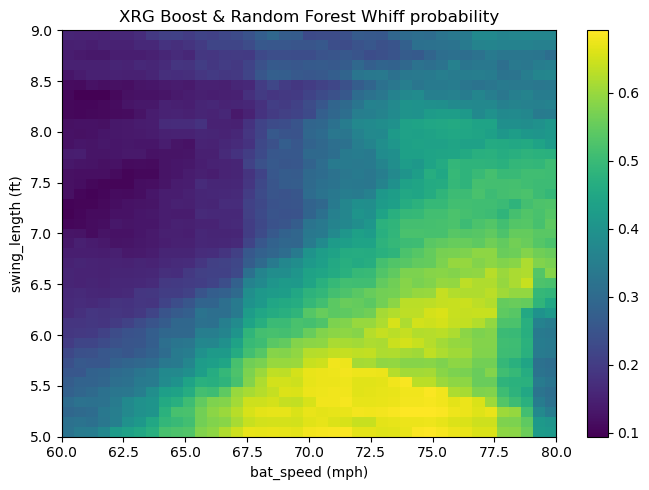

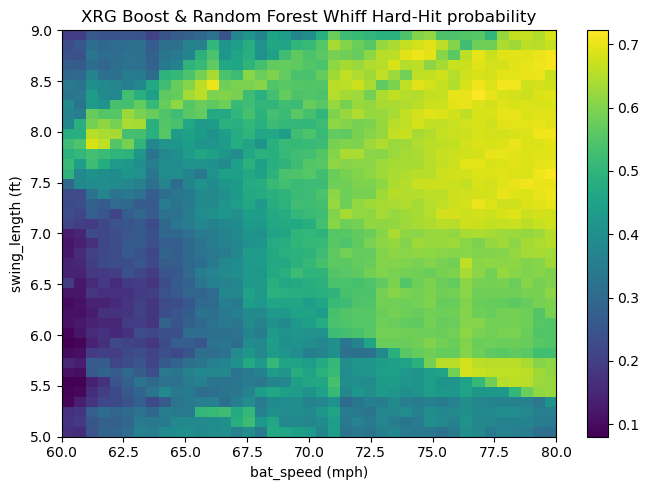

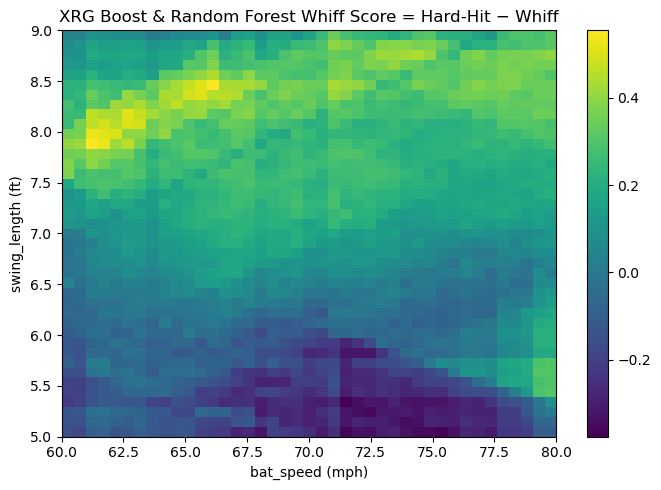

In [35]:
# pivot to 2D for plotting
#cell 16
whiff_mat = grid_out.pivot(index="swing_length", columns="bat_speed", values="whiff_prob")
hard_mat  = grid_out.pivot(index="swing_length", columns="bat_speed", values="hardhit_prob")
score_mat = grid_out.pivot(index="swing_length", columns="bat_speed", values="score")

import matplotlib.pyplot as plt

def show_heat(mat, title, xlabel="bat_speed (mph)", ylabel="swing_length (ft)"):
    plt.figure(figsize=(7,5))
    plt.imshow(mat.values, aspect="auto", origin="lower",
               extent=[mat.columns.min(), mat.columns.max(),
                       mat.index.min(), mat.index.max()])
    plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()

show_heat(whiff_mat, "XRG Boost & Random Forest Whiff probability")
show_heat(hard_mat,  "XRG Boost & Random Forest Whiff Hard-Hit probability")
show_heat(score_mat, "XRG Boost & Random Forest Whiff Score = Hard-Hit − Whiff")


In [27]:
# Cell 18 — FIXED: build menus with complete feature columns

import numpy as np
import pandas as pd

base_feats = numeric_features + categorical_feats

# Build defaults from your training data
_ref = pd.concat(
    [sw[base_feats].copy(), ct[base_feats].copy()],
    axis=0, ignore_index=True
)
_num_default = {c: float(_ref[c].median()) for c in base_feats if c in _ref.columns and pd.api.types.is_numeric_dtype(_ref[c])}
_cat_default = {c: _ref[c].mode(dropna=True).iat[0] for c in base_feats if c in _ref.columns and not pd.api.types.is_numeric_dtype(_ref[c])}

def ensure_grid_features(g: pd.DataFrame) -> pd.DataFrame:
    g = g.copy()
    # add any missing numeric/categorical columns with defaults
    for c in base_feats:
        if c not in g.columns:
            if c in _num_default:
                g[c] = _num_default[c]
            elif c in _cat_default:
                g[c] = _cat_default[c]
            else:
                # final fallback
                g[c] = 0 if c in numeric_features else ""

    # rebuild interactions if they are part of your feature list
    if "bs_div_sl" in base_feats and {"bat_speed","swing_length"}.issubset(g.columns):
        g["bs_div_sl"] = g["bat_speed"] / g["swing_length"]
    if "bs_mul_sl" in base_feats and {"bat_speed","swing_length"}.issubset(g.columns):
        g["bs_mul_sl"] = g["bat_speed"] * g["swing_length"]
    if "arm_angle" in base_feats and "arm_angle" not in g.columns:
        g["arm_angle"] = _num_default.get("arm_angle", 0.0)

    return g

def compute_band_for_context(ctx, n=10):
    g, _bs, _sl = make_grid()
    for k, v in ctx.items():
        g[k] = v
    g = ensure_grid_features(g)

    p_w = WHIFF_MODEL.predict_proba(g[base_feats])[:, 1]
    p_h = HARD_MODEL.predict_proba(g[base_feats])[:, 1]

    go = g[["bat_speed","swing_length"]].copy()
    go["whiff_prob"] = p_w
    go["hardhit_prob"] = p_h
    go["score"] = go["hardhit_prob"] - go["whiff_prob"]

    top = go.sort_values("score", ascending=False).head(n)

    def round_band(series, step):
        lo = (series.min()//step)*step
        hi = ((series.max()//step)+1)*step
        return float(lo), float(hi)

    bs_lo, bs_hi = round_band(top["bat_speed"], 1.0)
    sl_lo, sl_hi = round_band(top["swing_length"], 0.5)

    return {
        "context": ctx.copy(),
        "band_bat_speed_mph": [bs_lo, bs_hi],
        "band_swing_length_ft": [sl_lo, sl_hi],
        "avg_whiff%": float(top["whiff_prob"].mean()),
        "avg_hardhit%": float(top["hardhit_prob"].mean())
    }

# build menus
menus = []
menus.append(compute_band_for_context({**CTX, "pitch_type":"FF", "zone":2}))
menus.append(compute_band_for_context({**CTX, "pitch_type":"SL", "zone":14}))
menus.append(compute_band_for_context({**CTX, "pitch_type":"CH", "zone":8}))

pd.DataFrame(menus)


,context,band_bat_speed_mph,band_swing_length_ft,avg_whiff%,avg_hardhit%
0,"{'pitch_type': 'FF', 'zone': 2, 'balls': 0, 's...","[61.0, 67.0]","[7.5, 8.5]",0.134668,0.655252
1,"{'pitch_type': 'SL', 'zone': 14, 'balls': 0, '...","[69.0, 81.0]","[5.0, 7.5]",0.305467,0.599565
2,"{'pitch_type': 'CH', 'zone': 8, 'balls': 0, 's...","[61.0, 72.0]","[7.0, 8.0]",0.186947,0.606077


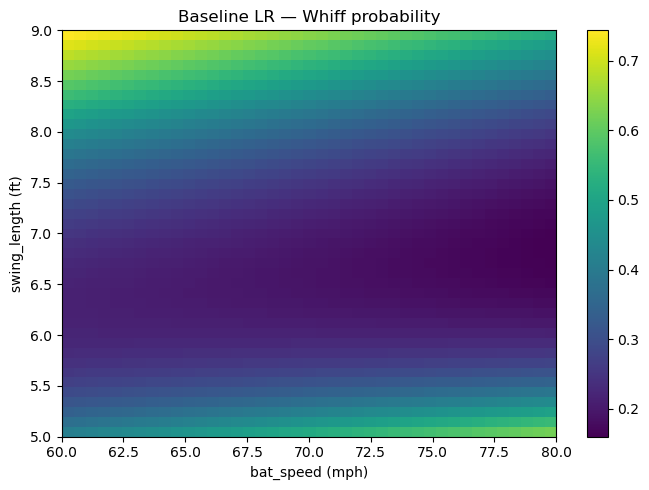

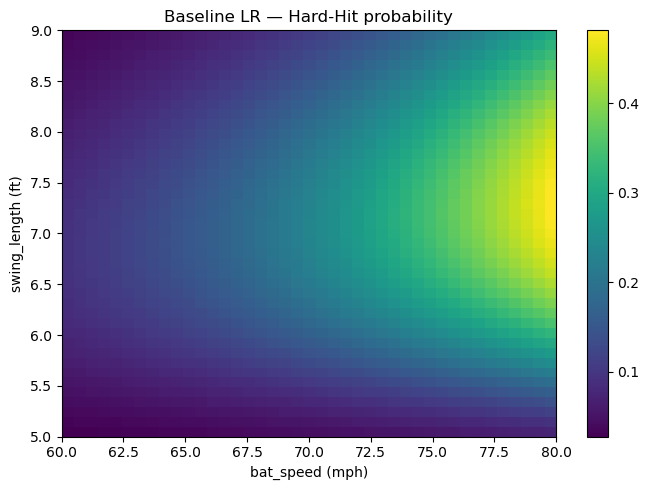

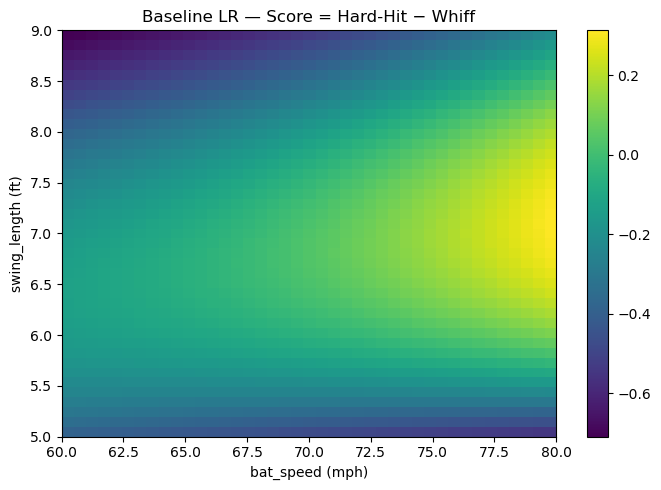

In [28]:
#cell 16.5
# Uses logistic baselines: pipe_whiff, pipe_hardhit
# Requires: grid (Cell 14), base_feats, ensure_grid_features (Cell 18), show_heat (Cell 16)

grid_bl = ensure_grid_features(grid)

p_whiff_bl = pipe_whiff.predict_proba(grid_bl[base_feats])[:, 1]
p_hard_bl  = pipe_hardhit.predict_proba(grid_bl[base_feats])[:, 1]

grid_bl_out = grid_bl[["bat_speed","swing_length"]].copy()
grid_bl_out["whiff_prob"]   = p_whiff_bl
grid_bl_out["hardhit_prob"] = p_hard_bl
grid_bl_out["score"]        = grid_bl_out["hardhit_prob"] - grid_bl_out["whiff_prob"]

whiff_bl = grid_bl_out.pivot(index="swing_length", columns="bat_speed", values="whiff_prob")
hard_bl  = grid_bl_out.pivot(index="swing_length", columns="bat_speed", values="hardhit_prob")
score_bl = grid_bl_out.pivot(index="swing_length", columns="bat_speed", values="score")

show_heat(whiff_bl, "Baseline LR — Whiff probability")
show_heat(hard_bl,  "Baseline LR — Hard-Hit probability")
show_heat(score_bl, "Baseline LR — Score = Hard-Hit − Whiff")




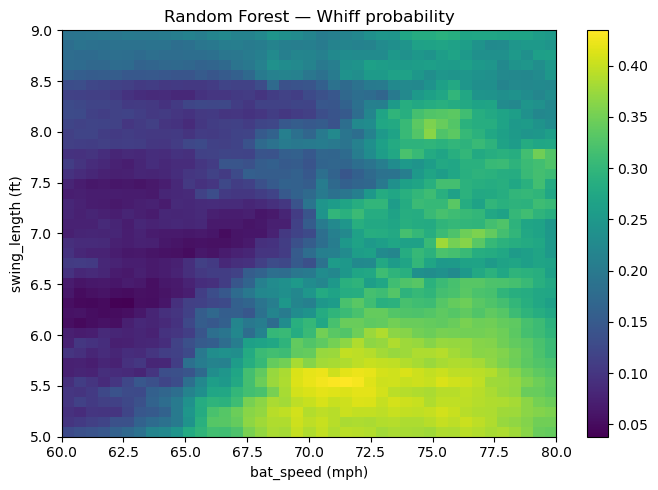

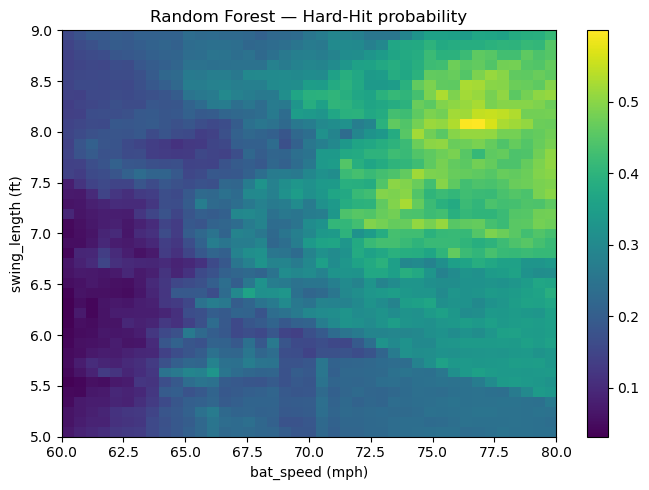

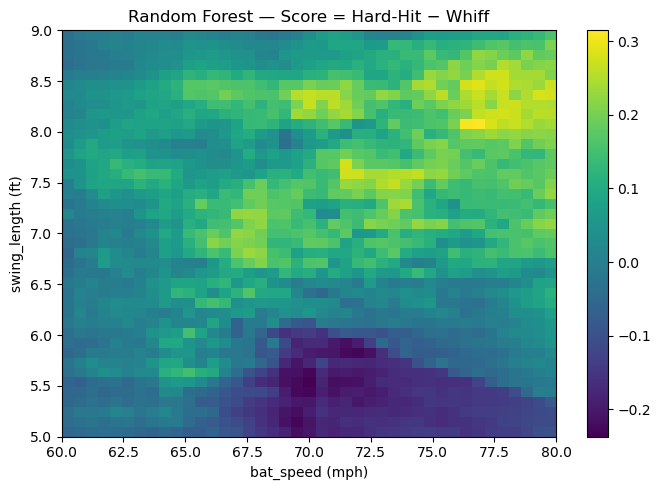

In [34]:
#16.6

# Uses RF: rf_whiff, rf_hard (from Cell 10)
# Requires: grid, base_feats, ensure_grid_features, show_heat

grid_rf = ensure_grid_features(grid)

p_whiff_rf = rf_whiff.predict_proba(grid_rf[base_feats])[:, 1]
p_hard_rf  = rf_hard.predict_proba(grid_rf[base_feats])[:, 1]

grid_rf_out = grid_rf[["bat_speed","swing_length"]].copy()
grid_rf_out["whiff_prob"]   = p_whiff_rf
grid_rf_out["hardhit_prob"] = p_hard_rf
grid_rf_out["score"]        = grid_rf_out["hardhit_prob"] - grid_rf_out["whiff_prob"]

whiff_rf = grid_rf_out.pivot(index="swing_length", columns="bat_speed", values="whiff_prob")
hard_rf  = grid_rf_out.pivot(index="swing_length", columns="bat_speed", values="hardhit_prob")
score_rf = grid_rf_out.pivot(index="swing_length", columns="bat_speed", values="score")

show_heat(whiff_rf, "Random Forest — Whiff probability")
show_heat(hard_rf,  "Random Forest — Hard-Hit probability")
show_heat(score_rf, "Random Forest — Score = Hard-Hit − Whiff")


In [33]:
#cell 17
# choose top-N cells, then expand to readable bands
N = 10  # inspect top 10 cells by score
top_cells = (grid_out.sort_values("score", ascending=False)
                      .head(N)
                      .reset_index(drop=True))

# bin into rounder bands for coaching
def round_band(series, step):
    lo = (series.min()//step)*step
    hi = ((series.max()//step)+1)*step
    return float(lo), float(hi)

bs_lo, bs_hi = round_band(top_cells["bat_speed"], 1.0)
sl_lo, sl_hi = round_band(top_cells["swing_length"], 0.5)

rules = {
    "context": CTX,
    "band_bat_speed_mph": [bs_lo, bs_hi],
    "band_swing_length_ft": [sl_lo, sl_hi],
    "avg_whiff%": float(top_cells["whiff_prob"].mean()),
    "avg_hardhit%": float(top_cells["hardhit_prob"].mean())
}
rules


{'context': {'pitch_type': 'FF',
  'zone': 2,
  'balls': 0,
  'strikes': 1,
  'outs_when_up': 0,
  'release_speed': 95.0,
  'effective_speed': 95.0,
  'plate_x': 0.0,
  'plate_z': 2.8,
  'stand': 'R',
  'p_throws': 'R',
  'inning_topbot': 'Top'},
 'band_bat_speed_mph': [61.0, 67.0],
 'band_swing_length_ft': [7.5, 8.5],
 'avg_whiff%': 0.13466811180114746,
 'avg_hardhit%': 0.6552518010139465}

In [30]:
#cell 19

outdir = Path("artifacts"); outdir.mkdir(exist_ok=True)
grid_out.to_parquet(outdir/"grid_predictions.parquet")
pd.DataFrame(menus).to_json(outdir/"training_bands.json", orient="records", indent=2)

# optional PNG saves
plt.imsave(outdir/"heat_whiff.png",  whiff_mat.values)
plt.imsave(outdir/"heat_hard.png",   hard_mat.values)
plt.imsave(outdir/"heat_score.png",  score_mat.values)


In [31]:
from pathlib import Path, PurePath
import os

print("cwd:", os.getcwd())          # where ./ points
outdir = Path("artifacts")           # same as ./artifacts
outdir.mkdir(exist_ok=True)
print("outdir:", outdir.resolve())   # absolute path
print("contents:", list(outdir.iterdir()))


cwd: C:\Users\matth
outdir: C:\Users\matth\artifacts
contents: [WindowsPath('artifacts/contacts.csv'), WindowsPath('artifacts/contacts.parquet'), WindowsPath('artifacts/features_categorical.csv'), WindowsPath('artifacts/features_numeric.csv'), WindowsPath('artifacts/grid_predictions.parquet'), WindowsPath('artifacts/heat_hard.png'), WindowsPath('artifacts/heat_score.png'), WindowsPath('artifacts/heat_whiff.png'), WindowsPath('artifacts/model_card.json'), WindowsPath('artifacts/model_hardhit_xgb.joblib'), WindowsPath('artifacts/model_whiff_xgb.joblib'), WindowsPath('artifacts/swings.csv'), WindowsPath('artifacts/swings.parquet'), WindowsPath('artifacts/training_bands.json')]
